In [1]:
##
#   COURSE: Neural signal processing and analysis: Zero to hero
#  SECTION: Synchronization problem set
#  TEACHER: Mike X Cohen, sincxpress.com
#

In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy.fft import fft, ifft
from scipy import signal as sp_signal
from tqdm import tqdm

## 1) All-to-all connectivity matrix

In this exercise, you are going to compute connectivity between all pairs of channels. It will create a channel X channel matrix.

First, import the v1 data and setup parameters for wavelet convolution at 8 hz and 55 hz.

In [2]:
# load in data
eeg_data = loadmat('../data/v1_laminar.mat', squeeze_me=True)
eeg_data['csd'].shape

(16, 1527, 200)

In [3]:
# useful variables for later...
nchans, npnts, ntrials = eeg_data['csd'].shape

In [4]:
# specify frequencies
frex = [8, 55]
nCycles = [7, 14]

In [5]:
# parameters for complex Morlet wavelets
# wavtime  = -1:1/srate:1-1/srate; # why remove a sample point?!
wavtime = np.arange(-1, 1, 1/eeg_data['srate']) 
half_wav = (len(wavtime)-1)/2

In [6]:
# FFT parameters
nWave = len(wavtime)
nData = npnts*ntrials
nConv = nWave+nData-1

In [7]:
# and create wavelets
cmwX = np.zeros((len(frex),nConv)) + 0j

for fi in range(len(frex)):
    s = nCycles[fi]/(2*np.pi*frex[fi])
    cmw = np.exp(2*1j*np.pi*frex[fi]*wavtime) * np.exp( (-wavtime**2) / (2*s**2) )
    tempX = fft(cmw,nConv)
    cmwX[fi,:] = tempX / np.max(tempX)

In [8]:
cmwX.shape

(2, 306925)

In [9]:
## run convolution to extract phase values (don't need power)
# store the phase angle time series in a 
#    channels X frequency X time X trials matrix

allphases = np.zeros((nchans,len(frex),npnts,ntrials))

In [10]:
# spectrum of all channels using the fft matrix input 
# (check the matrix sizes and FFT inputs!)
dataX = fft( np.reshape(eeg_data['csd'], (nchans,npnts*ntrials), order='F'), nConv, 1)

In [11]:
halfwave = int(round((len(wavtime)-1)/2))

In [12]:
for fi in range(len(frex)):
    # run convolution
    s = ifft( dataX * cmwX[fi,:] ,nConv, 1)
    s = s[:, halfwave+1:-halfwave]
    s = np.reshape(s, eeg_data['csd'].shape, order='F')
    
    # phase values from all trials
    allphases[:,fi,:,:] = np.angle(s)

In [13]:
allphases[0,0,0,1]

2.2697724290128334

In [14]:
## now compute connectivity
# Compute connectivity separately in two time windows:
#   .1 to .4, and .6 to .9 seconds.
# To do this, first compute synchronization over trials, then average the
#    synchronization values within those time windows.

In [15]:
# define time windows
tidx1 = [np.abs(eeg_data['timevec']- 0.1).argmin(),
         np.abs(eeg_data['timevec']- 0.4).argmin()]
tidx2 = [np.abs(eeg_data['timevec']- 0.6).argmin(),
         np.abs(eeg_data['timevec']- 0.9).argmin()]

In [16]:
tidx1, tidx2

([458, 687], [839, 1068])

In [17]:
# initialize a channels X channels X frequency X time period matrix
connmat = np.zeros((nchans,nchans,len(frex),2))
connmat.shape

(16, 16, 2, 2)

In [18]:
# in a double for-loop, compute phase synchronization between each pair
# inside the for-loop 
for chani in range(nchans):
    for chanj in range(nchans):
        
        # compute eulerized phase angle differences
        phasediffs = np.exp(1j* (allphases[chani,:,:,:]-allphases[chanj,:,:,:]) )
        
        # compute phase synchronization (ISPC) for all time points
        ispc = np.abs(np.mean(phasediffs,2))
        
        # get data averaged from the two time windows
        connmat[chani,chanj,:,0] = np.mean( ispc[:,tidx1[0]:tidx1[1]],1)
        connmat[chani,chanj,:,1] = np.mean( ispc[:,tidx2[0]:tidx2[1]],1)

In [19]:
## Make all-to-all connectivity plots
# In one figure, make six chan-by-chan matrices for 8 and 55 hz (upper and lower plots)
#   from averaged connectivity between .1-.4 s (left) and .6-.9 s (middle). 
# The right-most plot should show the difference of late-early connectivity.
# Use the same colorscaling for all 'raw' plots, 
#   and a different colorscaling for the difference plots.

# define color limits
clim  = [0, .8]
climD = [-.4, .4]

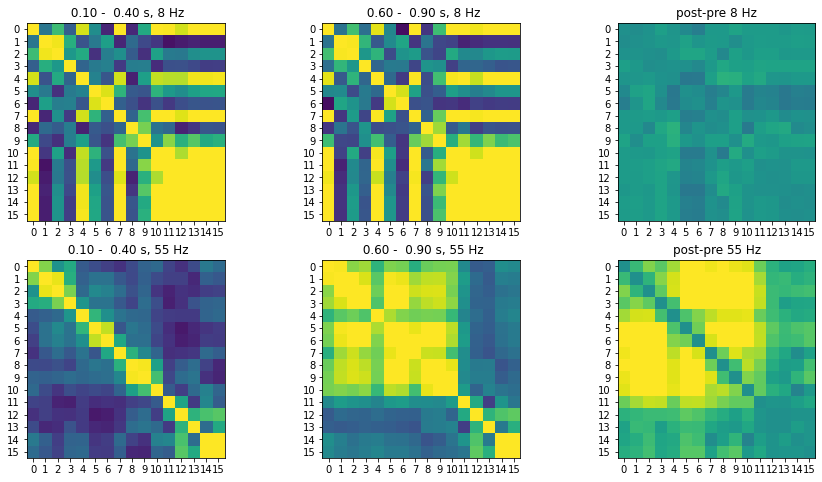

In [20]:
plt.figure(figsize=(15,8))
plt.subplot(231)
plt.imshow(connmat[:,:,0,0])
plt.clim(clim)
plt.xticks(range(nchans))
plt.yticks(range(nchans))
plt.title(f"{eeg_data['timevec'][tidx1[0]]: .2f} - {eeg_data['timevec'][tidx1[1]]: .2f} s, {frex[0]} Hz")

plt.subplot(232)
plt.imshow(connmat[:,:,0,1])
plt.clim(clim)
plt.xticks(range(nchans))
plt.yticks(range(nchans))
plt.title(f"{eeg_data['timevec'][tidx2[0]]: .2f} - {eeg_data['timevec'][tidx2[1]]: .2f} s, {frex[0]} Hz")

plt.subplot(233)
plt.imshow(connmat[:,:,0,1] - connmat[:,:,0,0])
plt.clim(climD)
plt.xticks(range(nchans))
plt.yticks(range(nchans))
plt.title(f"post-pre {frex[0]} Hz")

plt.subplot(234)
plt.imshow(connmat[:,:,1,0])
plt.clim(clim)
plt.xticks(range(nchans))
plt.yticks(range(nchans))
plt.title(f"{eeg_data['timevec'][tidx1[0]]: .2f} - {eeg_data['timevec'][tidx1[1]]: .2f} s, {frex[1]} Hz")

plt.subplot(235)
plt.imshow(connmat[:,:,1,1])
plt.clim(clim)
plt.xticks(range(nchans))
plt.yticks(range(nchans))
plt.title(f"{eeg_data['timevec'][tidx2[0]]: .2f} - {eeg_data['timevec'][tidx2[1]]: .2f} s, {frex[1]} Hz")

plt.subplot(236)
plt.imshow(connmat[:,:,1,1] - connmat[:,:,1,0])
plt.clim(climD)
plt.xticks(range(nchans))
plt.yticks(range(nchans))
plt.title(f"post-pre {frex[1]} Hz")

plt.show()

## 2) Seeded synchronization with topographical maps.

The goal of this assignment is to explore "seeded" synchronization, which means synchronization from one electrode to all other electrodes.

In [21]:
# load in the sample EEG dataset
eeg_data = loadmat('../data/sampleEEGdata.mat')

In [22]:
pnts = eeg_data['EEG']['pnts'][0][0][0][0]
trials = eeg_data['EEG']['trials'][0][0][0][0]
srate = eeg_data['EEG']['srate'][0][0][0][0]
nbchan = eeg_data['EEG']['nbchan'][0][0][0][0]
EEG_data = eeg_data['EEG']['data'][0][0]
times = eeg_data['EEG']['times'][0][0][0]

In [23]:
## Perform wavelet convolution on all channels/trials. Save the single-trial phase data for all channels.
#  Don't worry about the power data.

# soft-coded parameters for time-frequency analysis
freqrange = [2, 40]
numfrex = 50
numcycles = np.linspace(3,9,numfrex)

In [24]:
wavtime = np.arange(-2, 2, 1/srate) 
frex = np.linspace(freqrange[0],freqrange[1],numfrex)
nData = pnts*trials
nKern = len(wavtime)
nConv = nData + nKern - 1
halfwave = int(round((len(wavtime)-1)/2))

In [25]:
# create wavelets
waveletsX = np.zeros((numfrex,nConv)) + 0j

for fi in range(numfrex):
    
    s = numcycles[fi]/(2*np.pi*frex[fi])
    cmw = np.exp(2*1j*np.pi*frex[fi]*wavtime) * np.exp( (-wavtime**2) / (2*s**2) )
    waveletsX[fi,:] = fft(cmw,nConv)

In [50]:
# initialize matrix to store all phase values
allphases = np.zeros((nbchan,numfrex,pnts,trials))

In [66]:
# now do convolution!
# loop over channels
for chani in range(nbchan):
    
    # compute Fourier coefficients of EEG data (doesn't change over frequency!)
    eegX = fft( np.reshape(EEG_data[chani,:,:], (1, nData), order='F') ,nConv)
    
    # loop over frequencies
    for fi in range(numfrex):
        # second and third steps of convolution
        s = ifft( eegX * waveletsX[fi,:] ,nConv, 1)
        s = s[:, halfwave-1:-halfwave]
        # reshape to time X trials
        s = np.reshape(s, (pnts, trials), order='F')

         # save phase values from all time points and trials
        allphases[chani,fi,:,:] = np.angle(s)

In [67]:
# Compute FCz-to-all and Oz-to-all connectivity in the window of 0-600 ms
# from 8-12 Hz. Show topoplots.
# Then compute connectivity from -600 to 0. Subtract to show task-related
# connectivity. Interpret in context of volume conduction.

tidx1 = [np.abs(times - 0).argmin(),
         np.abs(times - 600).argmin()]
tidx2 = [np.abs(times + 600).argmin(),
         np.abs(times - 0).argmin()]

# frequency indices
fidx = [np.abs(frex - 8).argmin(),
         np.abs(frex - 12).argmin()]

In [68]:
labels = list(np.hstack(eeg_data['EEG']['chanlocs'][0][0]['labels'][0]))
FCzidx = labels.index('FCz')
Ozidx = labels.index('Oz')
FCzidx, Ozidx

(46, 28)

In [69]:
fcz_seeded_synch = np.zeros((2, nbchan))
oz_seeded_synch = np.zeros((2, nbchan))

In [70]:
# loop over channels
for chani in range(nbchan):
    
    # compute complex unit vectors defined by phase angle differences
    # from the 'seed' channel to the looping channel
    fcz_euler = np.exp(1j* (allphases[chani,:,:,:]-allphases[FCzidx,:,:,:] ) )
    oz_euler = np.exp(1j* (allphases[chani,:,:,:]-allphases[Ozidx,:,:,:] ) )
    
    # compute ITPC seeded synchronization over all time-frequency points
    synch_fcz_all = np.abs(np.mean(fcz_euler,2))
    synch_oz_all  = np.abs(np.mean(oz_euler,2))
    
    # extract average synchronization from the time-frequency windows
    fcz_seeded_synch[0, chani] = np.mean(np.mean(synch_fcz_all[fidx[0]:fidx[1],tidx1[0]:tidx1[1]],1))
    oz_seeded_synch[0, chani] = np.mean(np.mean(synch_oz_all[fidx[0]:fidx[1],tidx1[0]:tidx1[1]],1))
    
    fcz_seeded_synch[1, chani] = np.mean(np.mean(synch_fcz_all[fidx[0]:fidx[1],tidx2[0]:tidx2[1]],1))
    oz_seeded_synch[1, chani] = np.mean(np.mean(synch_oz_all[fidx[0]:fidx[1],tidx2[0]:tidx2[1]],1))

In [71]:
# use the same color limit
clim = [0, 1] # for the 'raw' synchronization
climdiff = [-.1, .1] # for the difference in synchronization

In [72]:
biosemi_montage = mne.channels.make_standard_montage('biosemi64')
info = mne.create_info(ch_names=labels, 
                       sfreq=srate,
                       ch_types='eeg')

In [87]:
np.reshape(np.diff(fcz_seeded_synch, axis=0), (-1, 1))

array([[-0.02241404],
       [-0.05243662],
       [ 0.00850373],
       [-0.0059264 ],
       [-0.03764751],
       [-0.03727867],
       [-0.04027009],
       [-0.0322781 ],
       [-0.00368859],
       [-0.01207331],
       [-0.00753601],
       [ 0.02154735],
       [ 0.01355276],
       [ 0.00210863],
       [ 0.00934318],
       [-0.00134565],
       [ 0.01825775],
       [ 0.03256293],
       [ 0.04814258],
       [ 0.04899987],
       [ 0.01581403],
       [-0.0185927 ],
       [-0.01898164],
       [-0.08686632],
       [-0.04558285],
       [ 0.03639104],
       [-0.01883359],
       [-0.06881067],
       [-0.00677153],
       [ 0.04561371],
       [ 0.06678916],
       [ 0.06305166],
       [ 0.00843794],
       [ 0.02021254],
       [ 0.01545568],
       [ 0.03633276],
       [ 0.02919693],
       [ 0.01215129],
       [ 0.03165661],
       [ 0.03843331],
       [ 0.01770206],
       [ 0.00456654],
       [ 0.00423486],
       [ 0.00472344],
       [ 0.00261933],
       [-0

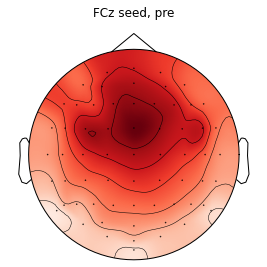

In [74]:
evoked = mne.EvokedArray(np.reshape(fcz_seeded_synch[1], (-1, 1)), info)
evoked.set_montage(biosemi_montage)

plt.title('FCz seed, pre')
mne.viz.plot_topomap(data=evoked.data[:,0], 
                     pos=evoked.info,
                     names=labels)
plt.show()

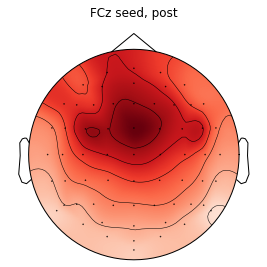

In [75]:
evoked = mne.EvokedArray(np.reshape(fcz_seeded_synch[0], (-1, 1)), info)
evoked.set_montage(biosemi_montage)

plt.title('FCz seed, post')
mne.viz.plot_topomap(data=evoked.data[:,0], 
                     pos=evoked.info,
                     names=labels)
plt.show()

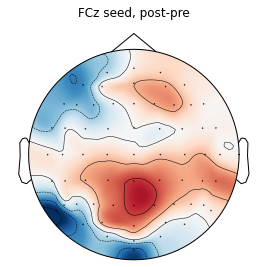

In [76]:
evoked = mne.EvokedArray(np.reshape(np.diff(fcz_seeded_synch, axis=0), (-1, 1)), info)
evoked.set_montage(biosemi_montage)

plt.title('FCz seed, post-pre')
mne.viz.plot_topomap(data=evoked.data[:,0], 
                     pos=evoked.info,
                     names=labels)
plt.show()

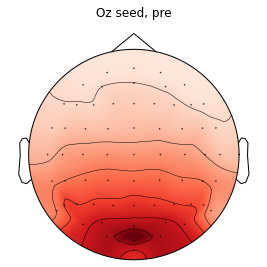

In [77]:
evoked = mne.EvokedArray(np.reshape(oz_seeded_synch[1], (-1, 1)), info)
evoked.set_montage(biosemi_montage)

plt.title('Oz seed, pre')
mne.viz.plot_topomap(data=evoked.data[:,0], 
                     pos=evoked.info,
                     names=labels)
plt.show()

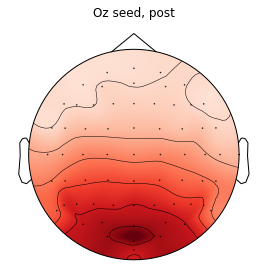

In [78]:
evoked = mne.EvokedArray(np.reshape(oz_seeded_synch[0], (-1, 1)), info)
evoked.set_montage(biosemi_montage)

plt.title('Oz seed, post')
mne.viz.plot_topomap(data=evoked.data[:,0], 
                     pos=evoked.info,
                     names=labels)
plt.show()

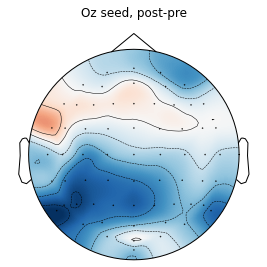

In [79]:
evoked = mne.EvokedArray(np.reshape(np.diff(oz_seeded_synch, axis=0), (-1, 1)), info)
evoked.set_montage(biosemi_montage)

plt.title('Oz seed, post-pre')
mne.viz.plot_topomap(data=evoked.data[:,0], 
                     pos=evoked.info,
                     names=labels)
plt.show()